In [1]:
import scipy
import scipy.io
import numpy as np
from scipy.linalg import norm
from scipy.sparse import csr_matrix
from scipy.linalg import norm
import pickle
import time
from collections import defaultdict
import json
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import pandas as pd
import numpy.matlib
import import_ipynb
import Poisson as ps
import FW
import SCOPT as sc
#import SCOPT


importing Jupyter notebook from Poisson.ipynb
importing Jupyter notebook from FW.ipynb
importing Jupyter notebook from SCOPT.ipynb


In [2]:
results = defaultdict(dict)
with open('./results/results_poisson_dict.pckl', 'rb') as f:
        results=pickle.load(f)

## Data load

In [3]:
example='a9a'
W, y = load_svmlight_file('./data/'+ example)
y = y.reshape(-1, 1)
W = W.toarray()

In [4]:
W.shape, y.shape

((32561, 123), (32561, 1))

In [5]:
#y = y.squeeze()

### Some preprocessing

In [6]:
# multiplicative multiplication of the structure of the recognizable structure
W = numpy.matlib.repmat(y, 1, W.shape[1]) * W
# summation of feature descriptions
sA = np.sum(W, 1)
# if the sum of the string is negative, invert it
W[sA < 0, :] = -W[sA < 0, :]
# zero row deletion
W = W[sA != 0, :]
# W = scipy.sparse.csr_matrix(W)

In [7]:
Bias = 1
b = (Bias * y).squeeze()
b = np.abs(b)
if (b.any == 0):
    print(' Input parameter y error')

In [8]:
y = b
y.shape

(32561,)

In [9]:
N, n = W.shape
lam = 1 / 2 * np.sqrt(N)
Mf = max(2/np.sqrt(y))
nu = 2
I = np.eye(n)
Iv = np.ones(n)

#running parameters
x0 = np.ones(n) / n
terminate_tol = 1e-10

#parameters for FW
FW_params={
    'iter_FW':50000,
    'line_search_tol':1e-10,
}


sc_params={
    #parameters for SCOPT
    'iter_SC': 1000,
    'Lest': 'estimate', #estimate L
    'use_two_phase':False,
    #FISTA parameters
    'fista_type': 'mfista',
    'fista_tol': 1e-5,
    'fista_iter': 1000,
    #Conjugate Gradient Parameters
    'conj_grad_tol':1e-5,
    'conj_grad_iter':1000,
}

## Auxilary functions

In [10]:
func_x = lambda x: ps.poisson(W,y,lam,x)
grad_x = lambda x,dot_product: ps.grad_poisson(W, y, lam, x,dot_product)
grad_beta = lambda x,s,beta,dot_product,dot_product_s: ps.grad_poisson(W, y, lam, (1-beta)*x+beta*x,(1-beta)*dot_product+beta*dot_product_s)
hess_mult_x = lambda x,dot_product: ps.hess_mult(W, y, x, dot_product)
hess_mult_vec_x= lambda s,dot_product: ps.hess_mult_vec(W, y, s, dot_product)
extra_func = lambda x: W@x
linear_orcale = lambda grad,M: ps.proj_simplex_full(grad, M,lam)
prox_func=lambda x: np.maximum(x,np.zeros(len(x)))

# Run FW

In [11]:
run_alpha_policies = ["standard","line_search","icml"]

for policy in run_alpha_policies:
    x, alpha_hist, Gap_hist, Q_hist, time_hist, grad_hist = FW.frank_wolfe(func_x,
                       grad_x,
                       grad_beta,
                       hess_mult_x,
                       extra_func,                                                    
                       Mf,
                       linear_orcale,                                                    
                       x0,
                       FW_params,        
                       alpha_policy=policy,                                                    
                       eps=terminate_tol, 
                       print_every=1000, 
                       debug_info=False)
    
    results[example][policy] = {
        'x': x,
        'alpha_hist': alpha_hist,
        'Gap_hist': Gap_hist,
        'Q_hist': Q_hist,
        'time_hist': time_hist,
        'grad_hist': grad_hist
    }
    

********* Algorithm starts *********
iter = 1, stepsize = 0.6666666666666666, criterion = 1.0, upper_bound=74847.9848381503, lower_bound=-74847.9848381503
iter = 1000, stepsize = 0.001996007984031936, criterion = 0.0019960079840319806, upper_bound=32922.98750499013, lower_bound=32103.48038269494
iter = 2000, stepsize = 0.000999000999000999, criterion = 0.000999000999000969, upper_bound=32922.98750499013, lower_bound=32103.48038269494
iter = 3000, stepsize = 0.0006662225183211193, criterion = 0.000666222518321145, upper_bound=32922.98750499013, lower_bound=32103.48038269494
iter = 4000, stepsize = 0.0004997501249375312, criterion = 0.0004997501249375221, upper_bound=32922.98750499013, lower_bound=32103.48038269494
iter = 5000, stepsize = 0.00039984006397441024, criterion = 0.0003998400639744218, upper_bound=32922.98750499013, lower_bound=32103.48038269494
iter = 6000, stepsize = 0.0003332222592469177, criterion = 0.00033322225924697186, upper_bound=32922.98750499013, lower_bound=32103.4

## Run SCOPT

In [12]:
 x, alpha_hist, Q_hist, time_hist, grad_hist = sc.scopt(func_x,
          grad_x,
          hess_mult_x,
          hess_mult_vec_x,
          Mf,
          nu,
          prox_func,
          x0,  
          sc_params,                                              
          eps=terminate_tol,                                              
          print_every=10)
    
results[example]['scopt'] = {
    'x': x,
    'alpha_hist': alpha_hist,
    'Gap_hist': Gap_hist,
    'Q_hist': Q_hist,
    'time_hist': time_hist,
    'grad_hist': grad_hist
}

iter =    1, stepsize = 6.507e-01, rdiff = 6.189e-01 , f = 74848

Convergence achieved!
iter =    6, stepsize = 0.000e+00, rdiff = 0.000e+00,value=32904.3

44.739245653152466


## Save results

In [13]:
with open('./results/results_poisson_dict.pckl', 'wb') as f:
    pickle.dump(results, f)

## Summarize

In [14]:
print(example)

methods= ["standard","line_search","icml","scopt"]

for method in methods:
    
    x=results[example][method]['x']
    time_hist=results[example][method]['time_hist']
    Q_hist=results[example][method]['Q_hist']
    
    print(method)
    print("sum_x=%g,total_time=%3.3e,time_per_iter=%g,minimal_val=%g\n"%(sum(abs(x)),sum(time_hist),sum(time_hist)/(len(time_hist)-1),
        min(Q_hist)))


a9a
standard
sum_x=6.20465,total_time=2.989e+02,time_per_iter=0.00597722,minimal_val=32785.3

line_search
sum_x=2.52873,total_time=1.128e+00,time_per_iter=0.0626615,minimal_val=32796.2

icml
sum_x=2.4611,total_time=2.433e+00,time_per_iter=0.00772535,minimal_val=32846.4

scopt
sum_x=3.38437,total_time=4.474e+01,time_per_iter=7.45621,minimal_val=32904.3



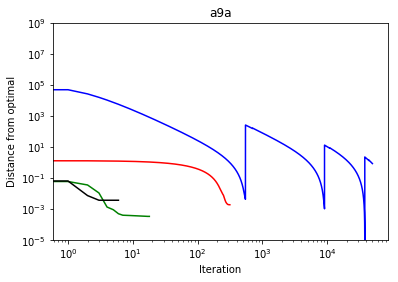

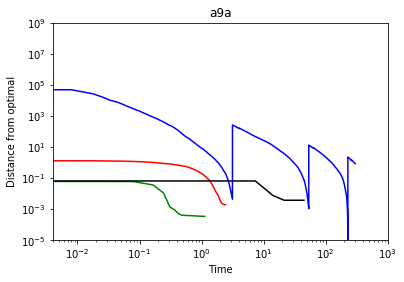

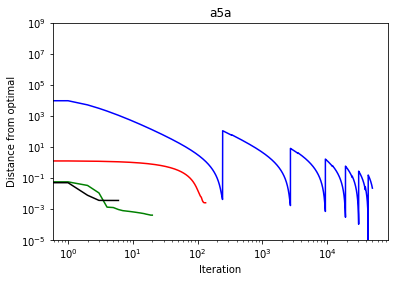

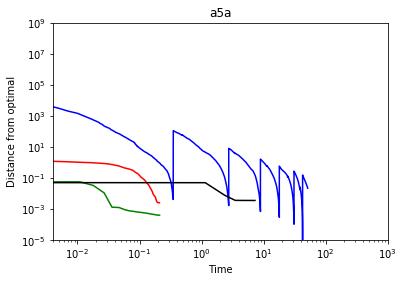

In [15]:
with open('./results/results_poisson_dict.pckl', 'rb') as f:
        results=pickle.load(f)
k=0
colors={'icml':'r','standard':'b','line_search':'g','scopt':'k'}
for example in ['a9a','a5a']:
    min_Q=1e10
    for method in methods:
        min_Q=min(min(results[example][method]['Q_hist']),min_Q)
    min_Q=min_Q-1e-10
        
    plt.figure(k)
    for method in methods:
        plt.loglog(results[example][method]['Q_hist']/min_Q-1,colors[method])
    plt.ylim((1e-5,1e+9))
    plt.xlabel('Iteration')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    
    k+=1
    plt.figure(k)
    for method in methods:
        plt.loglog(np.cumsum(results[example][method]['time_hist']),results[example][method]['Q_hist']/min_Q-1,colors[method])
    plt.xlim((0.4e-2,1e+3))
    plt.ylim((1e-5,1e+9))
    plt.xlabel('Time')
    plt.ylabel('Distance from optimal')
    plt.title(example)
    k+=1